In [1]:

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from torch.nn import functional as F

import time
import math

import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 1600
torch.manual_seed(RANDOM_SEED)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(torch.__version__)
device



2.2.0


device(type='cuda', index=0)

In [4]:
def create_data_loader(batch_size):
  # Split the provided CIFAR-10 train set (50,000 images) into your train and val sets
  # Use the first 40,000 images as your train set and the remaining 10,000 images as val set
  # Use all 10,000 images in the provided test set as your test set

  transform = transforms.Compose([
    transforms.ToTensor(),
      # This is the mean and the average of the cifar db because we are normalizing it.
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)), 
  ])

  # load cifar
  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # split train set into train and val
  train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

  # create data loaders
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=32)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True,num_workers=32)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True,num_workers=32)

  train_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in train_loader]
  val_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in val_loader]
  test_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in test_loader]


  return train_loader, val_loader, test_loader

In [5]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        
        if bias:
            self.bias = nn.Parameter(torch.randn(out_channels))
        else:
            self.register_parameter('bias', None)

        self.exponent = nn.Parameter(torch.ones(out_channels, in_channels, kernel_size, kernel_size))

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()
        pad = self.padding
        stride = self.stride
        kernel_size = self.kernel_size
        
        if pad > 0:
            x = F.pad(x, (pad, pad, pad, pad))

        out_height = (height + 2 * pad - kernel_size) // stride + 1
        out_width = (width + 2 * pad - kernel_size) // stride + 1

        x_unfold = F.unfold(x, kernel_size, stride=stride, padding=0)
        x_unfold = x_unfold.view(batch_size, in_channels, kernel_size, kernel_size, out_height, out_width)
        
        weight = self.weight.view(self.out_channels, self.in_channels, kernel_size, kernel_size, 1, 1)
        exponent = self.exponent.view(self.out_channels, self.in_channels, kernel_size, kernel_size, 1, 1)

        x_exp = x_unfold.unsqueeze(1) ** exponent

        out = (x_exp * weight).sum(dim=(2, 3, 4))
        
        if self.bias is not None:
            out += self.bias.view(1, -1, 1, 1)

        return out
class AddEpsilon(nn.Module):
    def __init__(self, epsilon=1e-10): # 1e-10 is smallest possible float in pytorch
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x + self.epsilon

class Net(nn.Module):
    def __init__(self, out_channels=10):
        super().__init__()
        self.conv2 = CustomConv2d(3, out_channels, 5)
        torch.manual_seed(RANDOM_SEED)
        self.fc1 = nn.Linear(out_channels * 28 * 28, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x 

In [6]:
def init_train_var(model):
  
  criterion = nn.CrossEntropyLoss()
  LEARNING_RATE = 0.005
  
  bias_params = [param for name, param in model.named_parameters() if "bias" in name]
  weight_params = [param for name, param in model.named_parameters() if "weight" in name]
  exponent_params = [param for name, param in model.named_parameters() if "exponent" in name]
  
  # optimizer = torch.optim.SGD([
  #     {"params": bias_params, "lr": LEARNING_RATE},
  #     {"params": weight_params, "lr": LEARNING_RATE},
  #     {"params": exponent_params, "lr": LEARNING_RATE*2*10}
  # ])

  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


  return criterion, optimizer

In [7]:
def test(model_path, test_loader):
  # use the provided test loader
  # return the test accuracy
  model = torch.load(model_path)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    test_acc = correct / total
  return test_acc


In [8]:
BATCH_SIZE = 128
train_loader, val_loader, test_loader = create_data_loader(batch_size=BATCH_SIZE)

model = Net()

# model = torch.compile(model)
# model = nn.DataParallel(model)
model = model.to(device)
# model = model.module.to(device)
criterion, optimizer = init_train_var(model)
total_epochs = 0


Files already downloaded and verified
Files already downloaded and verified


/usr/local/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
def print_statistical_info(data):
  data = data.view(data.size(0), -1)
  print(f"Max: {data.max().item()}")
  print(f"Min: {data.min().item()}")
  print(f"Mean: {data.mean().item()}")
  print(f"Std: {data.std().item()}")
  print("Count: ", data.size(0))
  print("\n")


print_statistical_info(train_loader[0][0])


Max: 1.0
Min: 0.0
Mean: 0.48062437772750854
Std: 0.25239986181259155
Count:  128




In [10]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []


# print a sample data loader
for i, (inputs, labels) in enumerate(train_loader):
    print(f"inputs {torch.max(inputs)}")
    print(f"inputs min {torch.min(inputs)}")
    print(f"Batch {i+1}:")
    print(f"  inputs size: {inputs.size()}")
    print(f"  labels size: {labels.size()}")
    break

In [18]:

EPOCH_COUNT = 200

In [19]:
%%time



for epoch in range(EPOCH_COUNT):
    model.train()
    train_loss = 0
    train_correct = 0
    # for each batch
    total_epochs += 1
    for i, (inputs, labels) in enumerate(train_loader):
        # count the number of weights with very small magnitute < 1e-3
        nans_count = 0
        for param in model.parameters():
            if param.grad is not None:
                nans_count += torch.sum(torch.isnan(param.grad)).item()
        
        # clamp exponents to avoid nans
        for name,param in model.named_parameters():
            if "exponent" in name:
                param.data = torch.clamp(param.data, 0.1, 1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print all gradients of the first synapse
        # print(f"synapse grads : {model.classifier[-1].synapses[0][0].main[0].grad}")
        # print(f"weights of first layer {model.classifier[-1].synapses[0][0]}")
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()


    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, total epochs is {total_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_correct/40000:.4f}')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct/40000)

    # validate
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct/10000
    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    



Epoch 1/200, total epochs is 401 Train Loss: 152.5902, Train Accuracy: 0.8623
Epoch 1/200, Val Loss: 166.0859, Val Accuracy: 0.4668
Epoch 2/200, total epochs is 402 Train Loss: 152.3151, Train Accuracy: 0.8627
Epoch 2/200, Val Loss: 166.2354, Val Accuracy: 0.4670
Epoch 3/200, total epochs is 403 Train Loss: 152.0380, Train Accuracy: 0.8630
Epoch 3/200, Val Loss: 166.3812, Val Accuracy: 0.4670
Epoch 4/200, total epochs is 404 Train Loss: 151.7635, Train Accuracy: 0.8632
Epoch 4/200, Val Loss: 166.5361, Val Accuracy: 0.4668
Epoch 5/200, total epochs is 405 Train Loss: 151.4886, Train Accuracy: 0.8636
Epoch 5/200, Val Loss: 166.6861, Val Accuracy: 0.4667
Epoch 6/200, total epochs is 406 Train Loss: 151.2172, Train Accuracy: 0.8638
Epoch 6/200, Val Loss: 166.8398, Val Accuracy: 0.4667
Epoch 7/200, total epochs is 407 Train Loss: 150.9441, Train Accuracy: 0.8641
Epoch 7/200, Val Loss: 166.9941, Val Accuracy: 0.4665
Epoch 8/200, total epochs is 408 Train Loss: 150.6748, Train Accuracy: 0.864

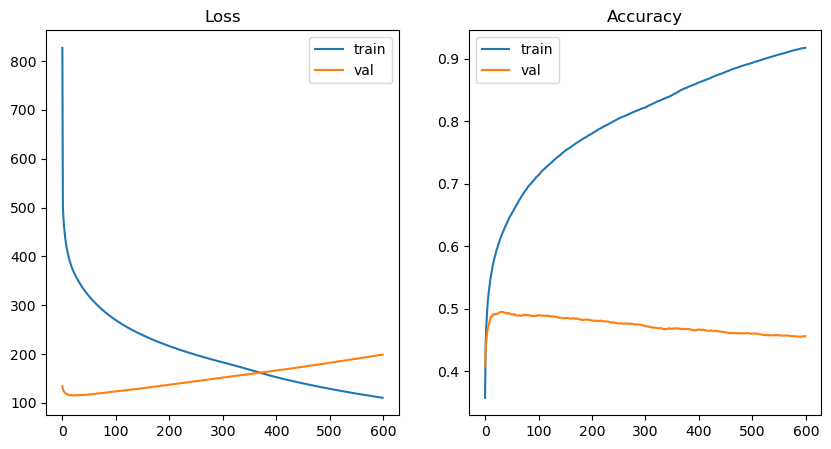

In [20]:
# plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='val')
plt.title('Accuracy')
plt.legend()



plt.show()



In [14]:
# print exponents in custon conv layer
# for name, param in model.named_parameters():
#     print(f"{name}")


In [15]:
# measure correlation between exponents and weights
exponents = []
weights = []
for name, param in model.named_parameters():
    if 'conv2.exponent' in name:
        exponents.append(param.data)
    if 'conv2.weight' in name:
        weights.append(param.data)

exponents = torch.cat(exponents, dim=0)
weights = torch.cat(weights, dim=0)

In [16]:

# normalize exponents and weights between 0 and 1
# exponents = (exponents - exponents.min()) / (exponents.max() - exponents.min())
# weights = (weights - weights.min()) / (weights.max() - weights.min())

# print size of exponents and weights
print(f"Exponents size: {exponents.size()}")
print(f"Weights size: {weights.size()}")

def correlation(x, y):
    x_mean = torch.mean(x)
    y_mean = torch.mean(y)
    x_centered = x - x_mean
    y_centered = y - y_mean
    numerator = torch.sum(x_centered * y_centered)
    denominator = torch.sqrt(torch.sum(x_centered**2) * torch.sum(y_centered**2))
    return numerator / denominator

correlation_value = correlation(exponents, weights)
print(f"Correlation between exponents and weights: {correlation_value}")


Exponents size: torch.Size([10, 3, 5, 5])
Weights size: torch.Size([10, 3, 5, 5])
Correlation between exponents and weights: -0.19370143115520477


In [17]:
exponents.mean(), exponents.std(), weights.mean(), weights.std()

(tensor(0.9609, device='cuda:0'),
 tensor(0.0639, device='cuda:0'),
 tensor(-0.0195, device='cuda:0'),
 tensor(1.1446, device='cuda:0'))